> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Before submitting your project, it will be a good idea to go back through your report and remove these sections to make the presentation of your work as tidy as possible. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset (Replace this with something more specific!)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction


The introduction:

The tmdb dataset contains about 100000movies. 

Here is the list of questions which I try to answer using this dataset.



Questions 
1)Find min, max, mean budget
2)Find movie titles which starts with "A"!)
3) Find most common director from that list)
4) Revenue of each year movies director)¶
5) Find most populat movies

Author: Kuat Bektayev

Dataset: tmdb-movies



In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html

# 
#

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you document your steps carefully and justify your cleaning decisions.

### General Properties

The dataset contains 21 columns 
and 10866 rows

In this section I will clean the dataset from the NULL values 
and investigate the main attributes

1. printing total rows and columns 
2. replacing 0 with NaN of runtime column of the dataframe
3. calling column which need to be formatted in datetime and storing those values in them
4. showing datatypes of all the columns
5. removing duplicated records



In [2]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.

#Loading dataset
df = pd.read_csv('tmdb-movies.csv')

#Printing dataset
df.head()






,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


In [1]:
#printing total rows and columns
df.shape

NameError: name 'df' is not defined

In [2]:
#replacing 0 with NaN of runtime column of the dataframe
movie_data['runtime'] = movie_data['runtime'].replace(0, np.NaN)

NameError: name 'movie_data' is not defined

In [3]:
#calling column which need to be formatted in datetime and storing those values in them
movie_data.release_date = pd.to_datetime(movie_data['release_date'])

NameError: name 'pd' is not defined

In [ ]:
#showing datatypes of all the columns
movie_data.dtypes

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

In [1]:
#removing duplicated records
df.duplicated()

NameError: name 'df' is not defined

> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).

### Data Cleaning (Replace this with more specific notes!)
1. Find out the string format of date column
2. Cleaning duplicate values
3. Deleting/replacing rows/column


In [21]:
#  Before answering questions we need a clean dataset
#  After discussing the structure of the data and any problems that need to be
#  cleaned, perform those cleaning steps in the second part of this section.
#


#Find out that column - release date - has string format. Converting it into date time
df.release_date = pd.to_datetime(df['release_date'])

In [23]:
#Printing
df.head(2)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,2015-05-13,6185,7.1,2015,1.379999e+08,3.481613e+08


In [25]:
#Cleaning duplicate values
df.drop_duplicates(inplace = True)

In [15]:
#Deleting and replacing rows/columns - 0 to NaN. Deleting NaN
df = df.replace(0,np.NaN)
df = df.dropna(subset =['genres'], inplace=True)

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Research Question 1 (Find the budget - max, min, mean)

In [4]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.
# find max budget
max = df['budget']
print(max.max())



NameError: name 'df' is not defined

In [12]:
# find min budget
min = df['budget']
print(min.min())

0


In [5]:
# find mean budget
mean = df['budget']
print(mean.mean())

NameError: name 'df' is not defined

In [ ]:
# Function which calculates lowest and highest values of columns


def highest_lowest(column_name):
    
    # high
    # index value of the highest number in profit column
    highest_id = movie_data[column_name].idxmax()
    # index number,storing that row info to a variable
    highest_details = pd.DataFrame(movie_data.loc[highest_id])
    
    # low
    # same processing as above
    lowest_id = movie_data[column_name].idxmin()
    lowest_details = pd.DataFrame(movie_data.loc[lowest_id])
    
    # concatenating two dataframes
    two_in_one_data = pd.concat([highest_details, lowest_details], axis = 1)
    
    return two_in_one_data

#calling the function and passing the argument
highest_lowest('profit_(in_US_Dollars)')

### Research Question 2  (Find movie titles which starts with "A"!)

In [5]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.

# substring to be searched 
sub ='A'
  
# creating and passsing series to new column 
original_title_a = df["oroiginal_title"].str.startswith(sub) 

print(original_title_a)



0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14        True
15       False
16       False
17        True
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
10836    False
10837    False
10838    False
10839    False
10840    False
10841    False
10842    False
10843    False
10844    False
10845    False
10846    False
10847    False
10848    False
10849    False
10850    False
10851    False
10852     True
10853     True
10854    False
10855    False
10856    False
10857    False
10858    False
10859    False
10860    False
10861    False
10862    False
10863    False
10864    False
10865    False
Name: original_title, Length: 10866, dtype: bool




### Research Question 3 (Find most common director from that list)

In [6]:
find_common_director = df['director']


df['director']

# count directors 
count_directors = df.pivot_table(index=['director'], aggfunc='size')
print (count_directors.sort_values(ascending=False))


director
Woody Allen                                  45
Clint Eastwood                               34
Steven Spielberg                             29
Martin Scorsese                              29
Ridley Scott                                 23
Steven Soderbergh                            22
Ron Howard                                   22
Joel Schumacher                              21
Brian De Palma                               20
Wes Craven                                   19
Barry Levinson                               19
Tim Burton                                   19
Mike Nichols                                 18
David Cronenberg                             18
John Carpenter                               18
Rob Reiner                                   18
Renny Harlin                                 17
Sidney Lumet                                 17
Oliver Stone                                 17
Francis Ford Coppola                         17
Spike Lee                      

# Research Question 4 (Revenue of each year  movies director)

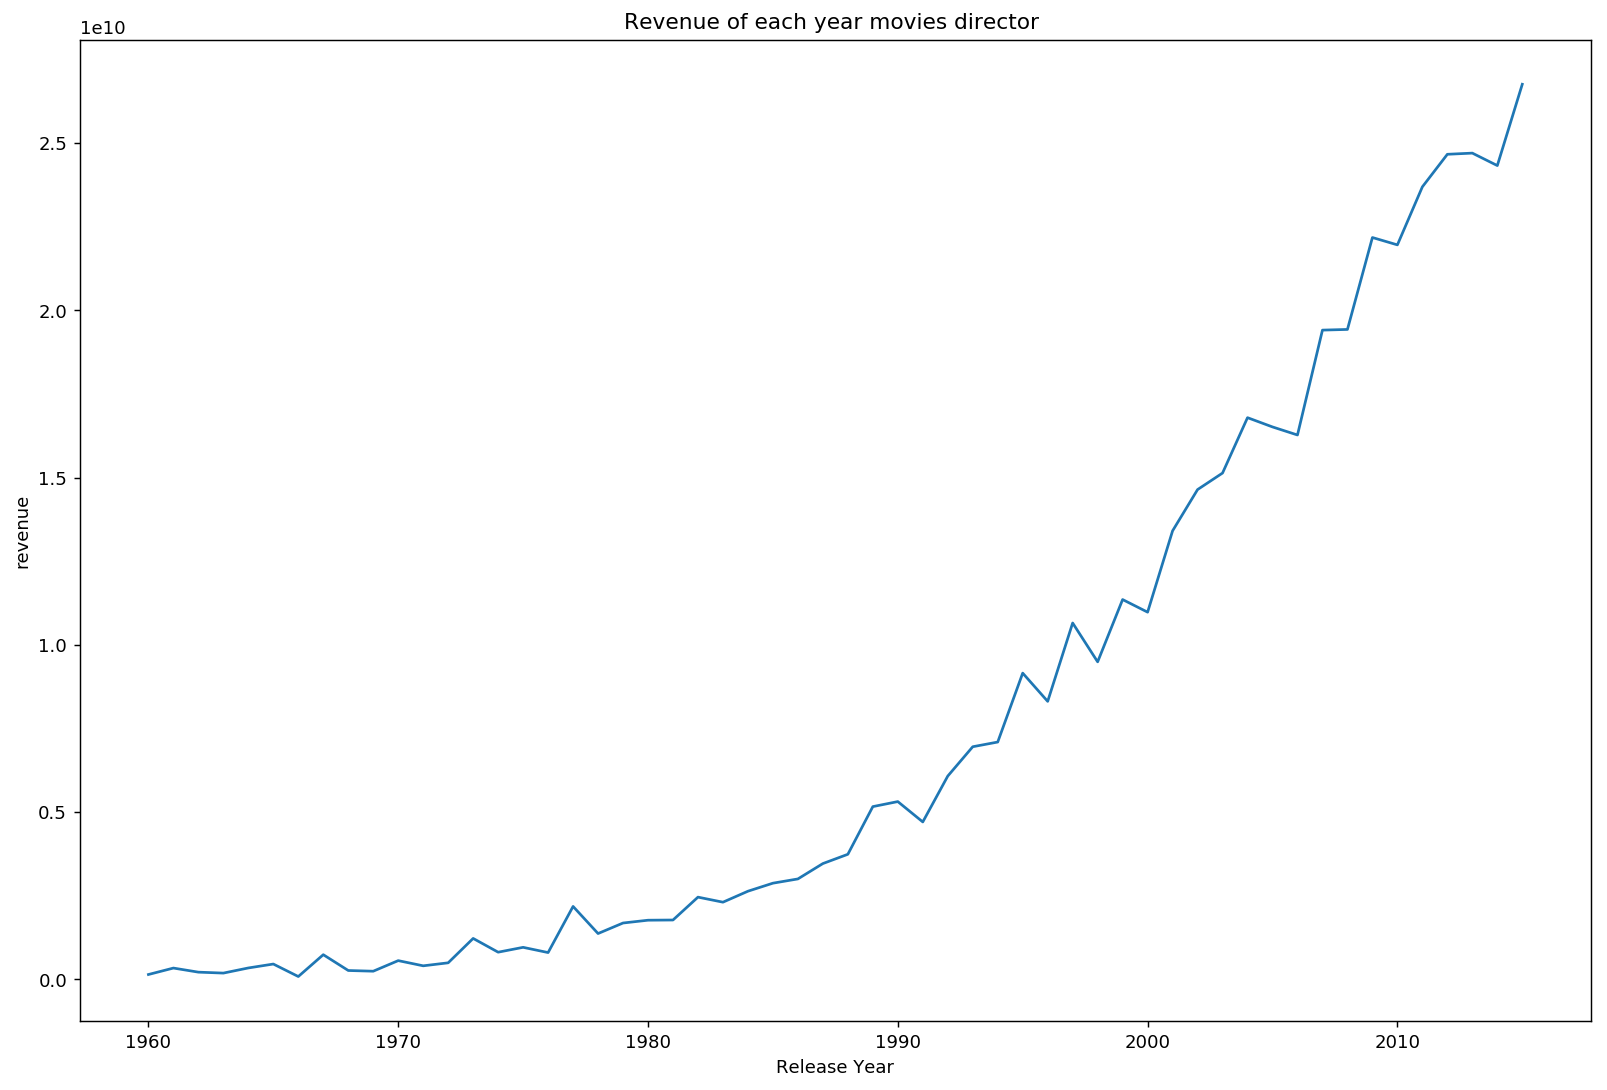

In [7]:
#Simply using line chart to demonstrate sum of revenue for each year 
year = df.groupby('release_year')['revenue'].sum()


plt.figure(figsize=(15,10), dpi=130)
#x-axis label
plt.xlabel('Release Year', fontsize = 10)
#y-axis label
plt.ylabel('revenue', fontsize = 10)
#title
plt.title('Revenue of each year ')
plt.plot(year)

plt.show()

# # Research Question 5 (Find most populat movies)

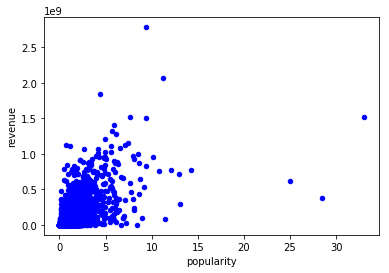

In [10]:
#Scatter plot shows how popularity affected to revenue. It is clearly seen that the -
# - popularity most of the movies around 1-10 and they have avg revenue.
# There are some outliers. Movies which have popularity above 25-30 but the revenue werent good.


df.plot(kind='scatter',x='popularity',y='revenue',color='blue')
plt.show()


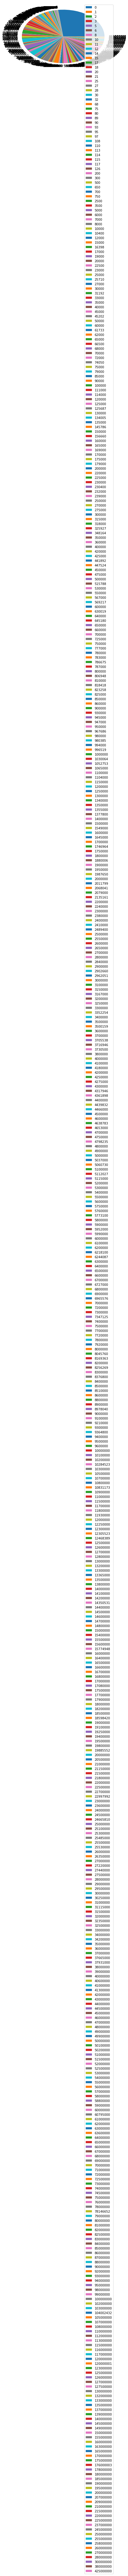

Conclusion

To sum up
In the following dataset we clearly found out the minimum and maximum budget which have been spent for movies.
Also within the dataset we found the movies whose title starts with char - A. The main reason was find and count the movie names which starts with char - A.

Within the list most popular director is - Woody Alen. He has around 45 movies which were directed by him.

Visualized the revenue for each year. It is clearly seen that the revenue was gradually increasing from 1960 till 1980. From 1980 it sharply went up and still growing.


Scatter plot helped to find  most popular movies


Limitations. 

In general all queries shows related data. In order to find deeper answer from dataset we need to create more hypothesis within this dataset and visualize it with proper charts. 


In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])